# Homework 2
# Introduction to Modeling with Python

## Goal
The goal of this project is to develop a model from a set of training data that will predict the sale price of houses with minimal root mean squared error. 

## Purpose
For this project, I will use [data](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) retrieved from a [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition to develop a model that will predict the sale price of houses. This exercise is designed to help me develop feature engineering skills and advanced regression techniques.

## Table of Contents
- Import the Data
- Clean and Visualize the Data
- Imputation
- Feature Engineering
- Trying Out Different Models
- Hyperparameter Tuning & Model Descriptions
- Understanding the Models
- Approaching the Final Model
- Summary

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm, skew 
from scipy.stats import uniform as sp_rand
import time

#Silencing deprication warnings
import warnings
warnings.filterwarnings("ignore")

#Import libraries for modeling and validation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC, BayesianRidge, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Import Data

In [2]:
#I am importing the train and test data files that I downloaded from Kaggle
train = pd.read_csv("file:///Users/Codis_Joben/Documents/Pythondocs/KaggleHousingDataHW2/train.csv")
test = pd.read_csv("file:///Users/Codis_Joben/Documents/Pythondocs/KaggleHousingDataHW2/test.csv")

#Set Id variable for submission
Id = test.Id

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Clean and Visualize the Data
There are bound to be some variables that correlate with the sales price stronger than others. In this section, I will be cleaning and visualizing the data to get an idea of how I want to structure my model to maximize efficiency. It won't be very practical to evaluate 79 different variables, especially if a good portion of those variables have an insignificant effect on the sales price of a house. The models I will be using later on will mostly deal with the large amount of variables, but I will remove any that are missing a lot of data and that don't seem essential.

I will start by taking a look at SalePrice to better understand the variable that we are tyring to predict.

In [6]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

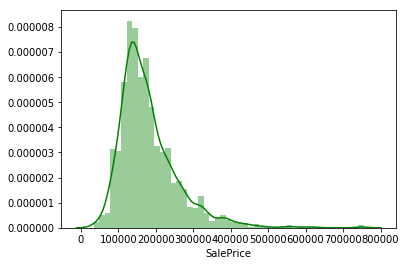

In [7]:
#Looking at the distribution
sns.distplot(train['SalePrice'], color = 'green')

This distribution has a large right tale. I will want to work with a normal distribution so that I can work with different regression models I will be using later on. I will make the change after I compare sale price to the other variables. 

Now I need to determine which variables are most relevant to the determination of the sale price of a house. I will see which variables are most strongly correlated and rule out the ones that have an insignificant impact. 

To get started, I am going to take a suggestion from Pedro Marcelino's Kaggle kernel that can be found [here](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python), and make some personal infernece on the variables that I think are most relevant to propsective home buyers and therefore more likely to affect the sale price. 

After reading the description of each variable (found on the info from Kaggle, link is at the top) I have determined that the following variables have a high likelihood of affecting the sale price:<br><br>

OverallQual (Overall Quality, not specified how they obtained this metric)<br>
YearBuilt <br>
TotalBsmtSF <br>
GrLivArea (Total sq foot living area above grade) <br>
TotRmsAbvGr (Total rooms above grade) <br>
BedroomAbvGr (This may not be much different than total rooms, but I will verify that later) <br>
GarageCars (Number of cars the garage fits) 

I will fist look at the quantitative variables and how they correlate to the SalePrice to see if my intuition is correct.

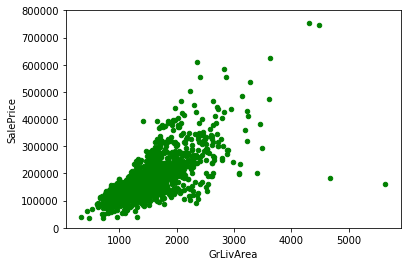

In [8]:
#Square footage of living area above grade
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), color = 'green');

There is a linear relationship between above grade square footage of living area and saleprice. This will be a key variable in my analysis. There are a couple of outliers that I want to get rid of. They are over 4000 sq ft and sold for less than 200,000, so we want to eliminate that data. Additionally, the author of the dataset (according to [juliensc](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)) recommends removing any house over 4000 sq ft.

In [9]:
train = train[train.GrLivArea < 4000]

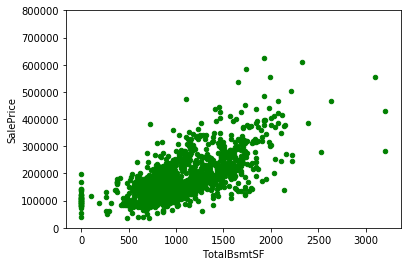

In [10]:
#Total square footage of the basement
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), color = 'green');

There is a strong linear relationship between above grade square footage of living area and sale price. This will also be a key variable in my analysis.

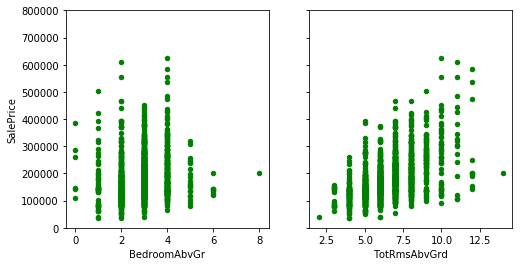

In [11]:
#Bedrooms and total rooms above grade
var1 = 'BedroomAbvGr'
var2 = 'TotRmsAbvGrd'
fig, (ax, ax2) = plt.subplots(1,2,figsize=(8, 4), sharey=True)
data1 = pd.concat([train['SalePrice'], train[var1]], axis=1)
data2 = pd.concat([train['SalePrice'], train[var2]], axis=1)
data1.plot.scatter(x=var1, y='SalePrice', ylim=(0,800000), ax=ax, color = 'green');
data2.plot.scatter(x=var2, y='SalePrice', ylim=(0,800000), ax=ax2, color = 'green');

The correlation between bedrooms above grade and SalePrice is not as insightful as I anticipated. There is a stronger linear correlation between total rooms above grade and SalePrice, but I don't think this observation is giving any additional information or insight that GrLivArea is already providing.

The drop off on Sale Price at 5+ bedrooms is very interesting. This could be from lack of data, but I am starting to think that too many bedrooms hurts the value of the home. Not many families require that many bedrooms, so the space they take up is space taken away from other valuable functions, like kitchen and living space. 

Now I will take a look at the categorical data.

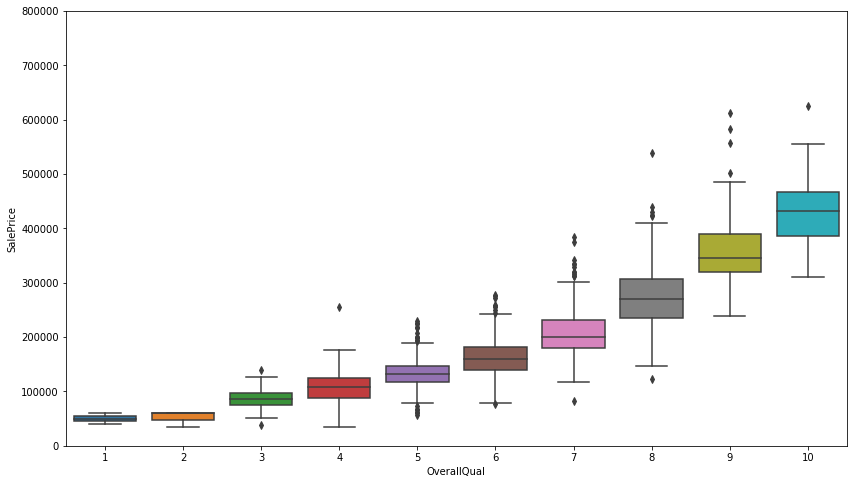

In [12]:
#Overall Quality of the home. Not sure how they measured this, but we will see how impactful it is on SalePrice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

There is a clear relationship between overall quality of the home and the sale price. This may be the strongest indicator for sale price. 

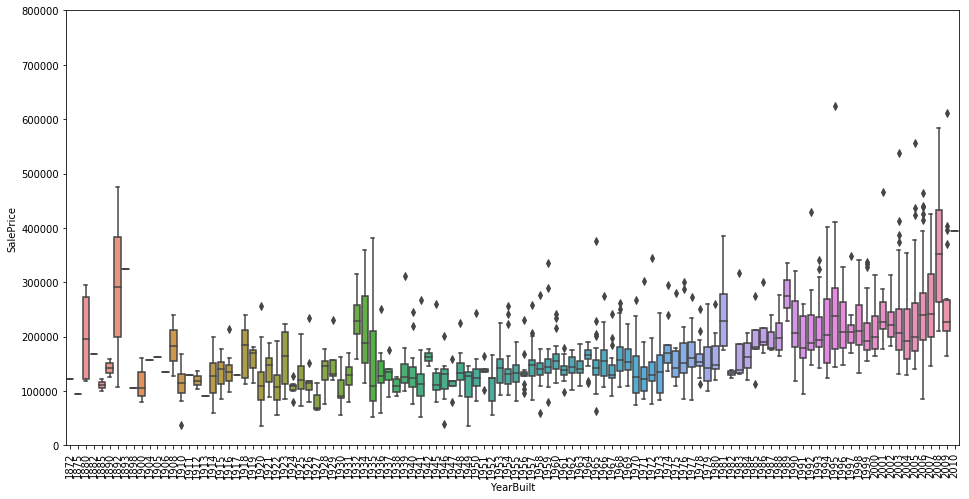

In [13]:
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

This relationship is not as strong as the overall quality of the home, but the sale price does tend to be higher for newer homes. 

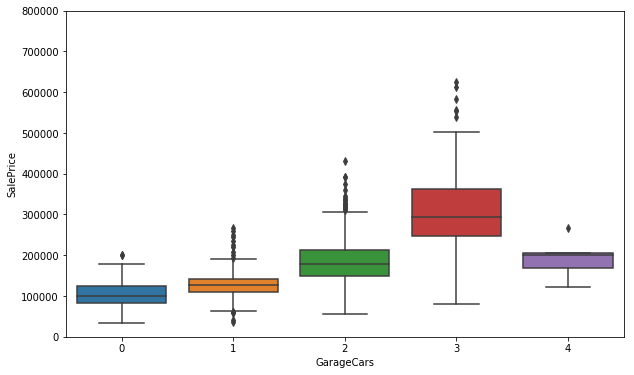

In [14]:
#How many cars the garage fits
var = 'GarageCars'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

There is a linear relationship up until 4 car garages. Clearly, homes with 3 car garages tend to be valued more than the others. 

In [15]:
#just finding the max of GrLivArea to help with the visualization of the following graph
train['GrLivArea'].max()

3627

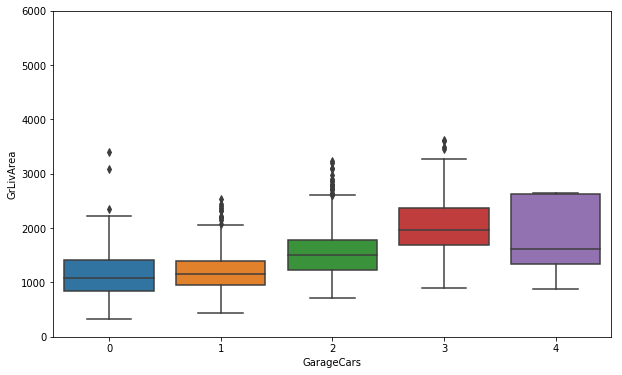

In [16]:
#I want to see how the capacity of the garage relates to the sq footage of above grade living space
var = 'GarageCars'
data = pd.concat([train['GrLivArea'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="GrLivArea", data=data)
fig.axis(ymin=0, ymax=6000);

Larger homes tend to have greater garage capacity, so this variable may not be necessary to evaluate if we are already looking at sq footage. 

Now that I have had some fun checking my intuition, it is time to let the data speak for itself. I will build a correlation map to see which variables are most strongly correlated with the SalePrice.

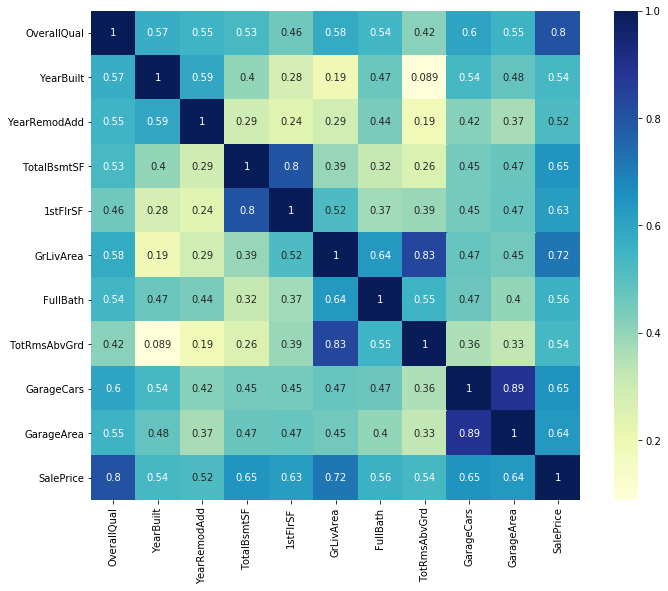

In [17]:
corr = train.corr()
#Filter the correlation to see the most correlated variables 
corr_filter = corr.index[abs(corr["SalePrice"])>0.5]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train[corr_filter].corr(), square = True, annot = True, cmap="YlGnBu")

Let's first observe the correlations between SalePrice and the other variables. Overall quality has a very strong impact, followed by above grade living area, garage characteristics, number of rooms, square footage of the basement, and the year it was built or remodeled. 

Looking at the relationship between the different variables aside from SalePrice will help identify collinearity and allow us to hone down the number of variables we need to look at. It would appear that the number of cars that fit in a garage is strongly correlated with the area of the garage. Total rooms and square footage of above grade living space is also strongly correlated. The basement square footage and the first floor square footage are also strongly correlated. This indicates that we may not need to worry too much about number of rooms, bathrooms, size of the first floor, and other information that is captured in certain variables, like above grade living area. 

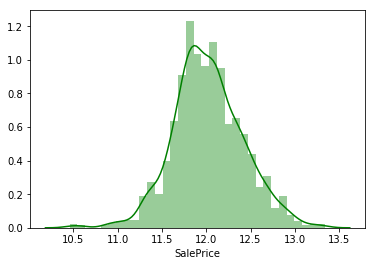

In [18]:
#Before moving on, I want to change SalePrice to achieve a normal distrubtion for my regression models
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'], color = 'green')

This will cause the errors in predicting cheap houses and expensive houses to affect the result equally.

Now that I have adjusted the SalePrice, I will store the variable in as a 'y' value for my models.

In [19]:
y = train['SalePrice']

# Imputation

In order for my models to work correctly, I need to make sure there are not any missing values in my data. This will keep our sample size from shrinking and shed light on any missing data that might be impactful to my analysis. 

Before I get started, I am going to merge my test and train data sets so that I can fix all the missing data at once.

In [20]:
n_train = train.shape[0]
data = pd.concat((train.drop('SalePrice', axis = 1), test)).reset_index(drop = True)
data = data.drop('Id', axis = 1)
n_train

1456

In [21]:
#Checking for missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageCond,159,0.054545
GarageQual,159,0.054545
GarageYrBlt,159,0.054545
GarageFinish,159,0.054545


Some variables are missing a ton of data, and I don't think they are relevant to our analysis anyways, so I will simply remove them from the data set (anything above 20% missing data). I will also drop utilities since they are all pretty much the same for each house.

In [22]:
data = data.drop((missing_data[missing_data['Percent'] > .2]).index,1)
data = data.drop('Utilities', axis = 1)

There is a lot of information missing for the variables that describe the garage and the basement. I already know that the size of the basement and garage are important, but I don't believe the details matter in our analysis. I also don't think the masonry veneer info is relevant to our analysis. I believe that the variable OverallQual captures enough information, so I will simply remove these variables. This should help my models to avoid overfitting if my assumption about the variables is correct.

In [23]:
#Fortunately, all the data mentioned above can be lumped within a range of percentage missing
data = data.drop((missing_data[(missing_data['Percent'] > .007) & (missing_data['Percent'] < .06)]).index,1)

Now that I've narrowed down the list of missing variables, I will fill in the missing data.

In [24]:
#Filling missing LotFrontage with the average LotFrontage of the other homes found in the same neighborhood
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [25]:
#Using a for loop to fill in numerical data that is most likely absent from the home with 0. 
numNA = ['BsmtHalfBath', 'BsmtFullBath', 'GarageCars', 'GarageArea', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF',
        'BsmtFinSF2']
for col in numNA:
    data[col] = data[col].fillna(0)

In [26]:
#Functional data description says NA means typical
data.loc[:, "Functional"] = data.loc[:, "Functional"].fillna("Typ")
#KitchenQual NA most likely means typical
data.loc[:, "KitchenQual"] = data.loc[:, "KitchenQual"].fillna("TA")

In [27]:
#These variables I will fill with the most common value in the rest of the data
most_common = ['MSZoning', 'SaleType', 'Electrical', 'Exterior2nd', 'Exterior1st']
for col in most_common:
    data[col] = data[col].fillna(data[col].mode()[0])

In [28]:
#Confirming that all missing values have been taken care of
data.isnull().any().sum()

0

# Feature Engineering

I will do some feature engineering to simplify and combine some of the variables in the data set to optimize my models. 

In [29]:
#Creating new features

#TotalSF = total square footage of house
data["TotalSF"] = data["GrLivArea"] + data["TotalBsmtSF"]
#TotalBath = total number of bathrooms
data["TotalBath"] = (data["BsmtFullBath"] + (0.5 * data["BsmtHalfBath"]) + data["FullBath"] + 
(0.5 * data["HalfBath"]))

Now I will be taking care of the skewness, or lack of symmetry, in the numerical data. In order to run regression on my data, it has to hold that all the variables are normal (not skewed). This is also why I took the natural log of my target variable, SalePrice, earlier in this analysis. 

Information on this process and help with the code came from [juliencs](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) and [ngriffiths13](https://github.com/ngriffiths13/Applied_Machine_Learning_Classwork/blob/master/Homeworks/HW2/Homework%202%20-%20Building%20a%20Regression%20Model.ipynb).

In [30]:
#Creating a variable to isolate the numerical variables in my data
num_data = data.select_dtypes(exclude = ["object"]).columns

#Checking the skew of all numerical data
skewed_data = data[num_data].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_data})
skewness.head(10)

,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.942892


In [31]:
#According to juliencs, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_data = skewness.index
lam = 0.15
for feat in skewed_data:
    #all_data[feat] += 1
    data[feat] = boxcox1p(data[feat], lam)

There are 36 skewed numerical features to Box Cox transform


Now I am going to convert the categorical data into numerical data so we can run our models. If I don't do this, the models will not run because they can't convert strings into floats... I learned this the hard way. This code will use dummy variables to take care of the categorical variables and prep them for modeling. 

In [32]:
#Get dummy variables
data = pd.get_dummies(data)

# Trying Out Different Models

Now I am going to get into some different models, compare them, and run a few test submission on them and get the lowest root mean squared error that I can possibly get at this stage. Ideas for which models to test have come from my Machine Learning lecture series by [tfolkman](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_4_Linear_Regression_and_Evaluation.ipynb), past work done on this assignment by [ngriffiths13](https://github.com/ngriffiths13/Applied_Machine_Learning_Classwork/blob/master/Homeworks/HW2/Homework%202%20-%20Building%20a%20Regression%20Model.ipynb), and information on this competition given by [Arun Godwin Patel](https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5).

In [33]:
#I am going to split the data into a test set and a training set so I can run a train_test_split
x = data[:n_train]
test = data[n_train:]

In [34]:
#Running a train_test_split to get a good idea of how my models will perform and what needs to be tuned up
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 220)
X_test : (437, 220)
y_train : (1019,)
y_test : (437,)


Plotting the learning curve from scikit-learn.org. Source link is found below.

In [35]:

## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [36]:
#This is a function that calculates the root mean square error of the model being evaluated
def get_rmse(model, x, y):
    scores = np.sqrt(-cross_val_score(model, x, y, cv = 5, scoring = 'neg_mean_squared_error'))
    return scores.mean()

BayesianRidge : RMSE = 0.11522884229007906


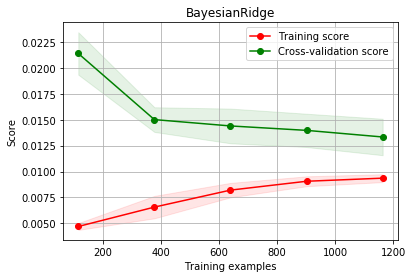

KernelRidge : RMSE = 0.11738648634126218


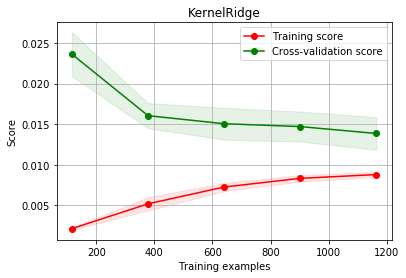

GradientBoostingRegressor : RMSE = 0.12009616737386486


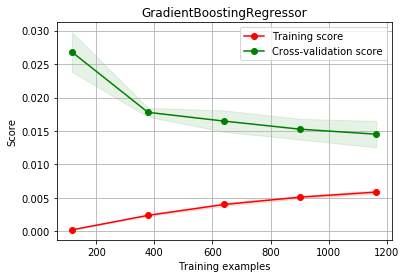

XGBRegressor : RMSE = 0.1204682203968912


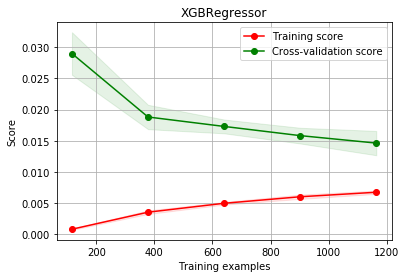

LGBMRegressor : RMSE = 0.12419813742994981


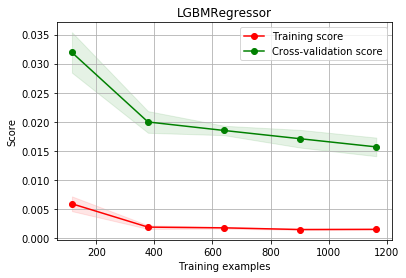

LassoLarsIC : RMSE = 0.12434561382549365


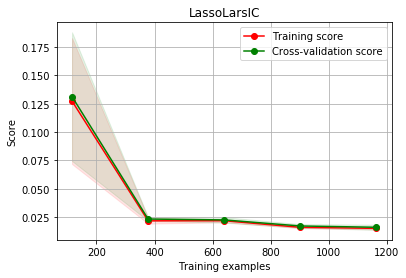

SVR : RMSE = 0.14414553590491766


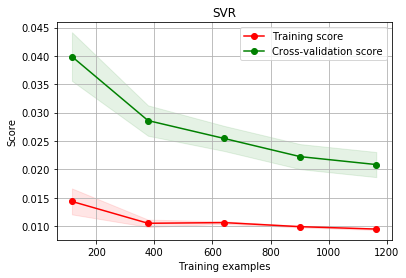

RandomForestRegressor : RMSE = 0.14110122978222112


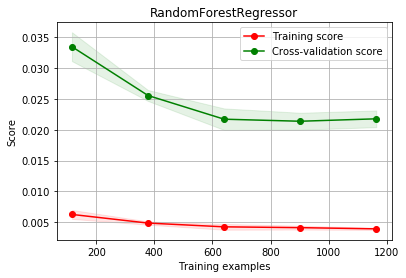

ElasticNet : RMSE = 0.38532560309199304


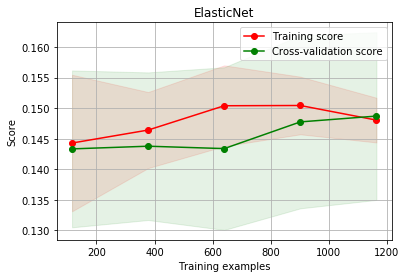

Lasso : RMSE = 0.39581263096952934


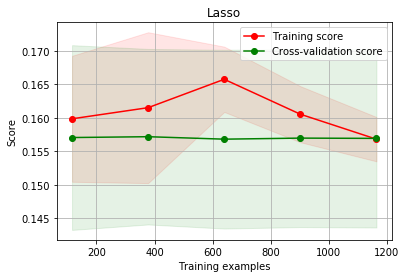

In [37]:
#This is a loop that will run through the different models, plot their learning curves, and allow me to compare RMSE
#I've sorted them somewhat in ascending order by RMSE
#I will provide a brief description of each model in the following section
br = BayesianRidge()
kr = KernelRidge()
gbr = GradientBoostingRegressor()
xgbr = XGBRegressor()
lgbm = lgb.LGBMRegressor()
lric = LassoLarsIC()
svr = SVR()
rfr = RandomForestRegressor()
en = ElasticNet()
las = Lasso()

reg = [br, kr, gbr, xgbr, lgbm, lric, svr, rfr, en, las]

for model in reg:
    scores = get_rmse(model, x, y)
    print(model.__class__.__name__,": RMSE =", scores)
    plot_learning_curve(model, model.__class__.__name__, x, y, cv = 5)
    plt.show()

I want to either fix or avoid the following conditions:<br><br>
**Bias**: The model doesn't do a good job fitting to the data. This will result in high RMSE.<br>
**Overfitting**: The model does much better on the training data than on the cross-validation data.<br><br>


**Models with High Bias**<br>
The following models have very high RMSE relative to the other models. There are a couple of ways to fix bias, by adding features or by trying a more complex model. I will tune the hyperparameters of these models to eliminate the high bias problems they are having. <br> 
- **Elastic Net**<br>
- **Lasso**

**Models that are Overfitting (High Variance)**<br>
The following models have a very large gap between their training scores and their test scores. They are learning too well on the training data but the end result is a poor prediction on the test data. I think doing some hyperparameter tuning will cause these models to perform much better. I have heard that the Random Forest Regressor, for example, generally performs very well with this kind of analysis. If I can't fix them through hyperparameter tuning then I will likely throw them out of my analysis. Variance issues can be fixed with more data, but I have a fixed amount of data so that doesn't help.<br>
- **LGBM Regressor**<br>
- **SVR**<br>
- **Random Forest Regressor**

**Models that Performed Well**<br>
These models do relatively well. The training and cross-validation scores are converging, so more data would improve their scores even more. I will do some hyperparameter tuning to maximize their scores.<br>
- **Bayesian Ridge**<br>
- **Kernel Ridge**<br>
- **Gradient Boosting Regressor**<br>
- **XGB Regressor**<br>
- **Lasso Lars IC**

Before I try and fix up these models, I want to do some test submissions and even play around with some combinations of models to see how they perform on the Kaggle competition.

In [38]:
#Running the model on the data
br_model = br.fit(x.values, y.values)
#The following code is converting my y values from log to the actual house price
br_pred = np.expm1(br_model.predict(test.values))

In [39]:
#exporting file for submission
submission = pd.DataFrame({'Id':Id,'SalePrice':br_pred})
submission.to_csv("submission.csv",index=False)

This Bayesian Ridge scored a **0.12542** on the Kaggle competition.

In [40]:
#Going to try to run two models and average the predicted values.
xgb_model = xgbr.fit(x.values, y.values)
xgb_pred = np.expm1(xgb_model.predict(test.values))

In [41]:
xgb_br_sub = pd.DataFrame({'Id':Id, 'SalePrice':((br_pred + xgb_pred)/2)})
xgb_br_sub.to_csv("submission.csv",index=False)

The average between the Bayesian Ridge and XGBRegressor models scored a **0.12494** on the Kaggle competition, sightly better than the Bayesian Ridge alone. 

In [42]:
#Lastly, I will get an average of the 4 models that performed the best and see if that can improve the score at all
kr_model = kr.fit(x.values, y.values)
kr_pred = np.expm1(kr_model.predict(test.values))
gbr_model = gbr.fit(x.values, y.values)
gbr_pred = np.expm1(gbr_model.predict(test.values))

In [43]:
combo_sub = pd.DataFrame({'Id':Id, 'SalePrice':((br_pred + xgb_pred + kr_pred + gbr_pred)/4)})
combo_sub.to_csv("submission.csv",index=False)

The average of all 4 top performing models scored a **0.12392** on the Kaggle competition, even better than the previous two submissions.

# Hyperparameter Tuning & Model Descriptions

In this section I will be tuning the hyperparameters of all my models to eliminate bias and hopefully boost RMSE scores. This should allow me to get to a finally model and prep for some basic stacking to send in my final submission for the Kaggle competition. 

I will be running the same basic code to tune the hyperparameters of each model. One some of the models, like the XGB Regressor, running a RandomSearchCV is too time consuming, so I am using hyperparemeter values that I have referenced from [ngriffiths13](https://github.com/ngriffiths13/Applied_Machine_Learning_Classwork/blob/master/Homeworks/HW2/Homework%202%20-%20Building%20a%20Regression%20Model.ipynb). 

I will also be including a brief description of each model.



I am going to start by tuning the hyperparameters of my best performing models according to their RMSE. 

## [Bayesian Ridge](https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html)

The Bayesian Ridge regression model is good because it can adapt to the data at hand and can be used to include regularization parameters in the estimation procedure. Its disadvantage is is a time consuming inference. 

In [44]:
#Checking the parameters for Bayesian Ridge
BayesianRidge().get_params

<bound method BaseEstimator.get_params of BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)>

In [47]:
#After playing around with the parameters a bit, these are the ranges of values I want to try and check to improve
#the BayesianRidge model.
br_params = {'alpha_1': np.arange(1e-7, 1e-5, 5e-7),
            'alpha_2': np.arange(1e-7, 1e-5, 5e-7),
            'lambda_1': np.arange(1e-7, 1e-5, 5e-7),
            'lambda_2': np.arange(1e-7, 1e-5, 5e-7),
            'n_iter': np.arange(100, 1000, 10),
            'tol': np.arange(.0001, .01, .001)}
br_t = RandomizedSearchCV(BayesianRidge(), param_distributions = br_params, n_iter = 100, cv = 5, 
                          scoring = 'neg_mean_squared_error')
br_t.fit(x,y)
br_t = br_t.best_estimator_

BayesianRidge : Origl_RMSE = 0.11522884229007942
BayesianRidge : Tuned_RMSE = 0.11522872259843005


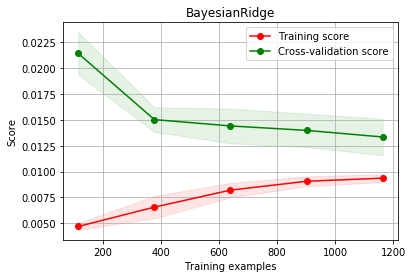

In [48]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(br, x, y)
print(br.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(br_t, x, y)
print(br_t.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(br_t, br_t.__class__.__name__, x, y, cv = 5)
plt.show()

So there was a slight improvement, but not much. I don't think I will be able to get a better RMSE with this amount of data using this model. 

## [Kernel Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick.

In [49]:
#Checking the parameters for Kernel Ridge
KernelRidge().get_params

<bound method BaseEstimator.get_params of KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)>

In [94]:
#I tried running RandomizedSearchCV to get a better score than the one ngriffiths13 got setting the paramaters
#Couldn't do better that way, so I took his parameters and tweaked them to get the best score possible

kr_t = KernelRidge(alpha=0.9, kernel='polynomial', degree=2, coef0=4.8)

KernelRidge : Origl_RMSE = 0.11738648634130418
KernelRidge : Tuned_RMSE = 0.11265374184403394


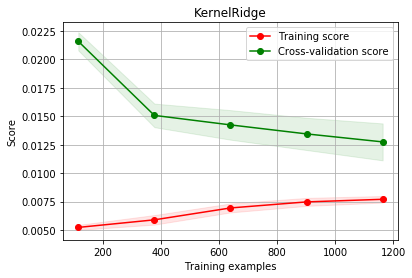

In [95]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(kr, x, y)
print(kr.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(kr_t, x, y)
print(kr_t.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(kr_t, kr_t.__class__.__name__, x, y, cv = 5)
plt.show()

After tuning the Kernel Ridge, I actually got a better RMSE than the Bayesian Ridge, so that is kinda cool. 

## [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function. Info on how to tune hyperparameters for this model can be found [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).

In [96]:
GradientBoostingRegressor().get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)>

In [103]:
#I ran RandomSearchCV to find the best parameters but it was taking a long time and the score was not improving much
#I have tweaked parameters originally used by ngriffiths13 to get a better score

gbr_t = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

GradientBoostingRegressor : Origl_RMSE = 0.12005807086284606
GradientBoostingRegressor : Tuned_RMSE = 0.11645895140418987


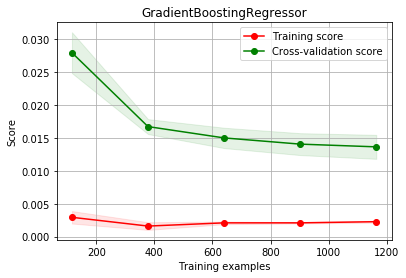

In [104]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(gbr, x, y)
print(gbr.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(gbr_t, x, y)
print(gbr_t.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(gbr_t, gbr_t.__class__.__name__, x, y, cv = 5)
plt.show()

This had some pretty good improvement.

## [XGB Regressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

The XGBoost Regressor is a ensemble of gradient boosted decision trees.

In [105]:
XGBRegressor().get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>

Running RandomSearchCV on the XGB Regressor takes way too long. After doing some research online to figure out the best way to tune this model for this data set, I came across this ensemble of XGB regressors that should improve its effectiveness on the data. The code was retrieved from [PhilipBall](https://www.kaggle.com/fiorenza2/journey-to-the-top-10). This ensemble is using the average of three different XGBRegressor models that use different seeds with the ideal hyperparameters to validate that the hyperparameters are generally good for the model and not overfitting to just one seed. 

In [106]:
#Running RandomSearchCV on the XGB Regressor takes way too long, more than several hours
from sklearn.base import BaseEstimator, RegressorMixin

class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append((regressor.predict(X).ravel()))
        return (np.mean(self.predictions_, axis=0))

In [107]:
xgb1 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=1200
                )

xgb2 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=1200,
                seed = 1234
                )

xgb3 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=1200,
                seed = 1337
                )

In [108]:
xgb_ens = CustomEnsembleRegressor([xgb1,xgb2,xgb3])

XGBRegressor : Origl_RMSE = 0.1204682203968912
CustomEnsembleRegressor : Tuned_RMSE = 0.11645895140418987


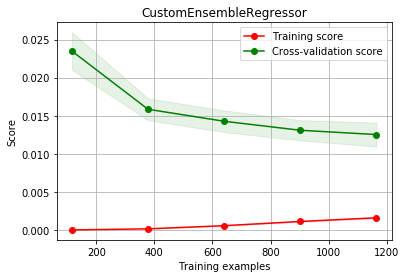

In [113]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(xgbr, x, y)
print(xgbr.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(gbr_t, x, y)
print(xgb_ens.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(xgb_ens, xgb_ens.__class__.__name__, x, y, cv = 5)
plt.show()

This tuning method has yielded a slightly better model than before. Interestingly enough, this XGB ensemble scored just as well as my tuned Gradient Boosting Regressor 

## [Lasso Lars IC](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html)

This is a Lasso model fit with Lars using BIC or AIC for model selection. AIC is the Akaike information criterion and BIC is the Bayes Information criterion. Such criteria are useful to select the value of the regularization parameter by making a trade-off between the goodness of fit and the complexity of the model. A good model should explain well the data while being simple.

In [114]:
LassoLarsIC().get_params

<bound method BaseEstimator.get_params of LassoLarsIC(copy_X=True, criterion='aic', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, normalize=True, positive=False,
      precompute='auto', verbose=False)>

In [115]:
lric_params = {'max_iter': np.arange(300, 800, 10),
               'copy_X': [True, False],
               'eps': np.arange(2.220446049250313e-17, 2.220446049250313e-15, 1e-16),
              'criterion': ['aic', 'bic']}
lric_t = RandomizedSearchCV(LassoLarsIC(), param_distributions = lric_params, n_iter = 50, cv = 5, 
                          scoring = 'neg_mean_squared_error')
lric_t.fit(x,y)
lric_t = lric_t.best_estimator_

LassoLarsIC : Origl_RMSE = 0.12434561382549365
LassoLarsIC : Tuned_RMSE = 0.12434561382549365


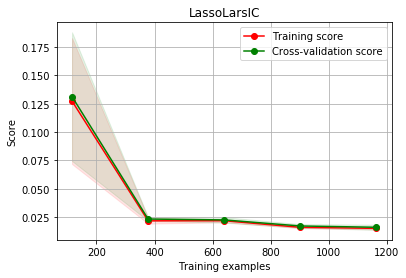

In [116]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(lric, x, y)
print(lric.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(lric_t, x, y)
print(lric_t.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(lric_t, lric_t.__class__.__name__, x, y, cv = 5)
plt.show()

So, after playing around with these hyperparameters, I could not get the RMSE to change at all. Not sure if this is something I am doing or if this type of model just isn't able to be tuned.

Now I am going to take a look at the two models that were showing a lot of bias. Tuning the hyperparameters on these models should yield some impressive results.

## [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

This model uses linear regression with combined L1 and L2 priors as regularizer.

In [117]:
ElasticNet().get_params

<bound method BaseEstimator.get_params of ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)>

In [121]:
en_params = {'l1_ratio': np.arange(0, 5, .1),
             'alpha': np.arange(.0001, .001, .0001),
            'selection' : ['cyclic', 'random']}
en_t = RandomizedSearchCV(ElasticNet(), param_distributions = en_params, n_iter = 50, cv = 5, 
                          scoring = 'neg_mean_squared_error')
en_t.fit(x,y)
en_t = en_t.best_estimator_

ElasticNet : Origl_RMSE = 0.38532560309199304
ElasticNet : Tuned_RMSE = 0.11286098865987655


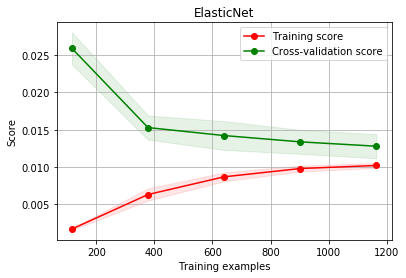

In [122]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(en, x, y)
print(en.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(en_t, x, y)
print(en_t.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(en_t, en_t.__class__.__name__, x, y, cv = 5)
plt.show()

Now that is what I am talking about. This model went from a dud to one of my best models. 

## [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

This is a linear Model trained with L1 prior as regularizer (aka the Lasso)

In [123]:
Lasso().get_params

<bound method BaseEstimator.get_params of Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)>

In [125]:
las_params = {'max_iter' : np.arange(500, 2000, 100),
             'selection' : ['cyclic', 'random'],
             'alpha' : np.arange(.0001, .001, .0001) }
las_t = RandomizedSearchCV(Lasso(), param_distributions = las_params, n_iter = 50, cv = 5, 
                          scoring = 'neg_mean_squared_error')
las_t.fit(x,y)
las_t = las_t.best_estimator_

Lasso : Origl_RMSE = 0.39581263096952934
Lasso : Tuned_RMSE = 0.11288033863375542


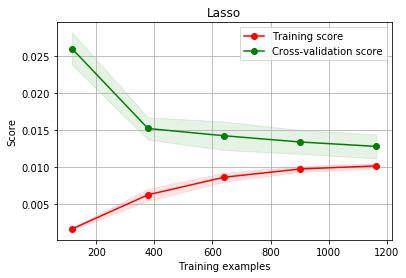

In [126]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(las, x, y)
print(las.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(las_t, x, y)
print(las_t.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(las_t, las_t.__class__.__name__, x, y, cv = 5)
plt.show()

This model was also improved significantly to nearly match the Elastic Net model.

Now it's time to tune my high variance models. 

## [LGBM Regressor](https://lightgbm.readthedocs.io/en/latest/Quick-Start.html)

The LightGB Regressor is another ensemble of gradient boosted decision trees that is slightly faster and sometimes more accurate than XGBoost.

In [127]:
lgb.LGBMRegressor().get_params

<bound method LGBMModel.get_params of LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>

In [128]:
#Running RandomSearchCV on the LGBMRegressor takes too much time.
#I will be drawing from ngriffiths13 hyperparameter tuning to tune this model.
lgbm_t = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

LGBMRegressor : Origl_RMSE = 0.12419813742994981
LGBMRegressor : Tuned_RMSE = 0.11460001371221333


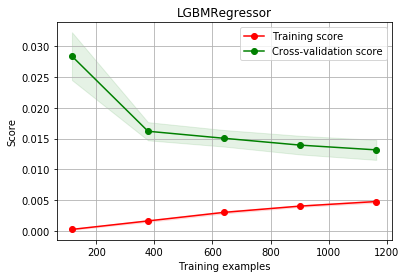

In [129]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(lgbm, x, y)
print(lgbm.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(lgbm_t, x, y)
print(lgbm_t.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(lgbm_t, lgbm_t.__class__.__name__, x, y, cv = 5)
plt.show()

There was slight improvement after tuning this model. 

## [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

Epsilon-Support Vector Regression

In [130]:
SVR().get_params

<bound method BaseEstimator.get_params of SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)>

In [131]:
svr_params = {'C' : np.arange(.1, 2, .1),
             'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
             'degree': np.arange(1, 7, 1),
             'coef0': np.arange(.0, 1, .1),
             'epsilon': np.arange(.1, 1, .1),
             'gamma': ['auto_deprecated', 'auto', 'scale'],
             'shrinking': [True, False],
             'cache_size': np.arange(100, 500, 50)}
svr_t = RandomizedSearchCV(SVR(), param_distributions = svr_params, n_iter = 50, cv = 5, 
                          scoring = 'neg_mean_squared_error')
svr_t.fit(x,y)
svr_t = svr_t.best_estimator_

SVR : Origl_RMSE = 0.14414553590491766
SVR : Tuned_RMSE = 0.1206836465324909


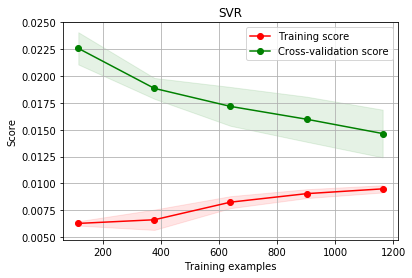

In [132]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(svr, x, y)
print(svr.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(svr_t, x, y)
print(svr_t.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(svr_t, svr_t.__class__.__name__, x, y, cv = 5)
plt.show()

Looks like there was some pretty good improvement in this model.

## [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

This is a random forest regressor. A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [133]:
RandomForestRegressor().get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

RandomSearchCV was taking too long to run, so I will be using hyperparameter values that I referenced from [towardsdatascience.com](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

In [134]:
rfr_t = RandomForestRegressor(bootstrap=True, max_depth=70, max_features='auto', min_samples_leaf=4,
 min_samples_split=10, n_estimators=400)

RandomForestRegressor : Origl_RMSE = 0.14087517032888702
RandomForestRegressor : Tuned_RMSE = 0.13830483042358055


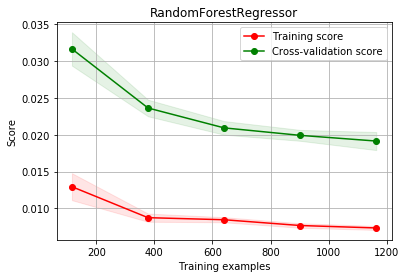

In [135]:
#plotting the new learning curve of the tuned model and comparing the scores of the original model
orig_scores = get_rmse(rfr, x, y)
print(rfr.__class__.__name__,": Origl_RMSE =", orig_scores)
scores = get_rmse(rfr_t, x, y)
print(rfr_t.__class__.__name__,": Tuned_RMSE =", scores)
plot_learning_curve(rfr_t, rfr_t.__class__.__name__, x, y, cv = 5)
plt.show()

There was some improvement after tuning, but this is still one of the models with the lowest performance.

# Understanding the Models

So I looked at 10 different models and tuned them up so they all perform about the same, but some are still better than others. I know that I want to take the average of the results of a combination of my best models, but at this point I am not sure which ones I will choose. It will take some trial and error to figure out which model combo yields the best RMSE scores for the Kaggle competition. 

Below is a ranking of my tuned models:
- 0.11265374184403394 **KernelRidge**
- 0.11286098865987655 **ElasticNet**
- 0.11288033863375542 **Lasso**
- 0.11460001371221333 **LGBMRegressor**
- 0.11522873335029873 **BayesianRidge**
- 0.11645895140418987 **XGBRegressor**
- 0.11645895140418987 **GradientBoostingRegressor**
- 0.12068364653249090 **SVR**
- 0.12434561382549365 **LassoLarsIC**
- 0.13830483042358055 **RandomForestRegressor**

I will take a closer look at the KernelRidge and ElasticNet models to understand what is going on inside.

In [136]:
#Creating a data frame that looks at the variables and their coefficients in this model
kr_t.fit(x.values, y.values)
featuresKR = pd.DataFrame(columns = ['Variable', 'Coef'])
featuresKR['Variable'] = list(x)
featuresKR['Coef'] = abs(en_t.coef_)
featuresKR.sort_values(by = 'Coef', ascending = False, inplace = True)
featuresKR = featuresKR[0:20]

Text(0.5, 1.0, 'Top 20 Variables in the Kernel Ridge Model')

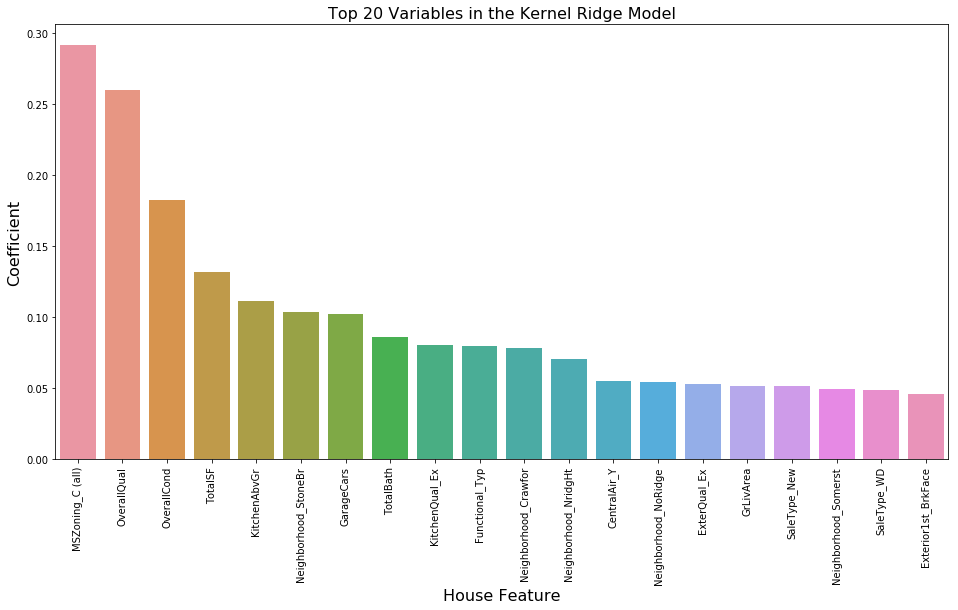

In [137]:
#Plotting the top 20 variables by their coefficient value
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
sns.barplot(x=featuresKR['Variable'], y = featuresKR['Coef'])
plt.xlabel('House Feature', fontsize=16)
plt.ylabel('Coefficient', fontsize=16)
plt.title('Top 20 Variables in the Kernel Ridge Model', fontsize=16)

This bar plot is showing the top 20 house features that impact SalePrice, according to the KernelRidge model. The first few variables have a far greater impact on the model than the others do. The two variables I created, TotalSF and TotalBath, had a significant impact on the model, which is nice to see. I find it interesting that one of the neighborhoods found its way into the top 10 variables, and a few others found their way into the top 20. This just goes to show that location is an important factor when it comes to house prices.

I would say that this model gives a good prediction for the sale price of the house. Based off of the features and the coefficients associated in the top 20, it seems pretty intuitive and related to consumer behavior. 

In [138]:
#Creating a data frame that looks at the variables and their coefficients in this model
en_t.fit(x.values, y.values)
featuresEN = pd.DataFrame(columns = ['Variable', 'Coef'])
featuresEN['Variable'] = list(x)
featuresEN['Coef'] = abs(en_t.coef_)
featuresEN.sort_values(by = 'Coef', ascending = False, inplace = True)
featuresEN = featuresEN[0:20]

Text(0.5, 1.0, 'Top 20 Variables in the Elastic Net Model')

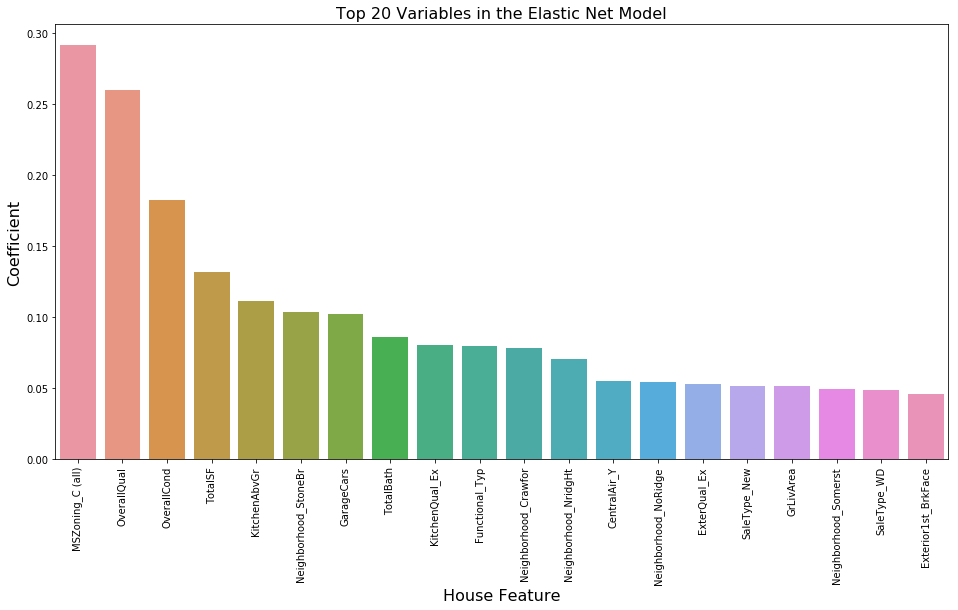

In [139]:
#Plotting the top 20 variables by their coefficient value
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
sns.barplot(x=featuresEN['Variable'], y = featuresEN['Coef'])
plt.xlabel('House Feature', fontsize=16)
plt.ylabel('Coefficient', fontsize=16)
plt.title('Top 20 Variables in the Elastic Net Model', fontsize=16)

The ElasticNet model is nearly identical to the Kernel Ridge model. I think there is only a placement difference between two variables. This could mean that for stacking, it may not be effective to use both of these models in a single stack since they are so similar.

# Approaching the Final Model

I am now going to play around with some stacking and averaging to get the best final model. 

In [143]:
#Running my tuned Kernel Ridge model to get my baseline RMSE score
kr_t.fit(x.values,y.values)
#The following code is converting my y values from log to the actual house price
kr_t_pred = np.expm1(kr_t.predict(test.values))

#exporting file for submission
submission = pd.DataFrame({'Id':Id,'SalePrice':kr_t_pred})
submission.to_csv("submission.csv",index=False)

My Kaggle score for this model was **0.12279**, which is lower than my previous submission of a combo of my top 4 raw models that scored 0.12392

In [144]:
#Throwing my top 5 models together to see how they perform
las_t.fit(x.values,y.values)
en_t.fit(x.values,y.values)
lgbm_t.fit(x.values,y.values)
br_t.fit(x.values,y.values)

las_t_pred = np.expm1(las_t.predict(test.values))
en_t_pred = np.expm1(en_t.predict(test.values))
lgbm_t_pred = np.expm1(lgbm_t.predict(test.values))
br_t_pred = np.expm1(br_t.predict(test.values))

submission = pd.DataFrame({'Id':Id,'SalePrice':((en_t_pred+las_t_pred+kr_t_pred+lgbm_t_pred+br_t_pred)/5)})
submission.to_csv("submission.csv",index=False)

This combo scored **0.12028**, which bumped me up several places on the Kaggle leaderboard.

In [146]:
#Getting predictions on the rest of my models with scores below .12 to test more combos
gbr_t.fit(x.values,y.values)
xgb_ens.fit(x.values,y.values)

gbr_t_pred = np.expm1(gbr_t.predict(test.values))
xgb_ens_pred = np.expm1(xgb_ens.predict(test.values))

#not sure if this will change anything, but I am going to average all 7 and see how it goes
submission = pd.DataFrame({'Id':Id,'SalePrice':((en_t_pred+las_t_pred+kr_t_pred+lgbm_t_pred+br_t_pred
                                                 +gbr_t_pred+xgb_ens_pred)/7)})
submission.to_csv("submission.csv",index=False)

This scored **0.11845**, an even better improvement! This feels great.

## Final Kaggle Score: 0.11845

# Summary

**Model Usefulness**<br>
<br>
I believe that this model is useful to get a general idea of what the sale price of a house may be given the data. Of course, this is old data and the housing market is changing all the time, so this model doesn't have any practical use as it stands right now. With enough training data, however, this model could continue to be useful for realtime predictions on current homes. The model will be able to adapt to the changing housing market as long as it is receiving updated information and continuing to train itself on the new data. <br><br>

Practically speaking, I don't think a company like Zillow would use a simple model like this. I believe they would want to have a model that is more complex and sofisticated. I think the model I developed lacks the ability to properly account for location (even though it did alright with assigning higher coefficients to the more affluent neighborhoods). It would be ideal to have a model that also takes into account the recent sale prices of homes that are within a close proximity of the home (like a mile or so), and not necessarily the homes within the same neighborhood or section of a city. <br><br>

I do think that this model is useful for getting an idea of what a house should go for generally speaking, without taking into account special cases (like an area that is experiencing a high volume of fire sales on foreclosed homes). It would be more ideally used broadly and not specifically, like as a national estimator that doesn't necessarily account for specific variables that are unique to a state or city. 

